In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import scipy.optimize
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy.interpolate import pchip_interpolate
import numpy as np
import math
from pandas import Series
from lmfit import Model, Parameter, report_fit
import scipy.ndimage
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from numpy import ones,vstack
from numpy.linalg import lstsq

In [2]:
files = glob.glob('../Dissertation_projects/Data/IRON/WC_FeT_Rerun/Fe_2124_25_26_27/*.txt')
files_nm = glob.glob('../Dissertation_projects/Data/IRON/WC_FeT_Rerun/Fe_2124_25_26_27/*p*.txt')

#here is where the output will go 
path_save_1 = '../Dissertation_projects/Data/IRON/WC_FeT_Rerun/Cruve_Fe_2124_25_26_27.csv'
path_save_2 = '../Dissertation_projects/Data/IRON/WC_FeT_Rerun/Fe_2124_25_26_27.csv'
files

['../Dissertation_projects/Data/IRON/WC_FeT_Rerun/Fe_2124_25_26_27\\000_nm_pre_Absorbance__1__14-59-49-444.txt',
 '../Dissertation_projects/Data/IRON/WC_FeT_Rerun/Fe_2124_25_26_27\\010_nm_post_Absorbance__0__15-55-24-079.txt',
 '../Dissertation_projects/Data/IRON/WC_FeT_Rerun/Fe_2124_25_26_27\\010_nm_pre_Absorbance__0__15-01-21-034.txt',
 '../Dissertation_projects/Data/IRON/WC_FeT_Rerun/Fe_2124_25_26_27\\020_nm_post_Absorbance__0__15-55-59-013.txt',
 '../Dissertation_projects/Data/IRON/WC_FeT_Rerun/Fe_2124_25_26_27\\020_nm_pre_Absorbance__0__15-02-04-016.txt',
 '../Dissertation_projects/Data/IRON/WC_FeT_Rerun/Fe_2124_25_26_27\\050_nm_post_Absorbance__0__15-56-32-244.txt',
 '../Dissertation_projects/Data/IRON/WC_FeT_Rerun/Fe_2124_25_26_27\\050_nm_pre_Absorbance__0__15-02-43-613.txt',
 '../Dissertation_projects/Data/IRON/WC_FeT_Rerun/Fe_2124_25_26_27\\100_nm_post_Absorbance__0__15-57-11-756.txt',
 '../Dissertation_projects/Data/IRON/WC_FeT_Rerun/Fe_2124_25_26_27\\100_nm_pre_Absorbance__0

In [3]:
def GET_DATA(name):
    df = pd.read_csv(name, skiprows=15, sep='\t', names=['wl', 'abs'], )
    df['abs'] = df['abs']
    #df['wl'] = df['wl']
    #bcorr = df[(df['wl']>=700) & (df['wl']<=701)]['abs'].mean() # a float corection with just 700 nm 
    bcorr = df[(df['wl']>=700) & (df['wl']<=750)]['abs'].mean() # a float corection with 700 to 750 nm 
    df['abs'] = df['abs'] - bcorr
    x = df['wl']
    y = df['abs'] 
    pchip_obj1 = scipy.interpolate.PchipInterpolator(x, y, axis=0, extrapolate=None)
    xi = np.arange(189,881,1)
    yi = pchip_obj1(xi)
    d = {'wl': xi, 'abs': yi}
    df = pd.DataFrame(d)
    return df

In [4]:
frames = []
for f in files:
    df = GET_DATA(f) # runs the processing function 
    ID = f.split("\\")[1] #takes junk out of the file name to make a single ID 
    df = df.rename(columns={'abs': ID}) # renames the abs col to the new id 
    df = df.set_index('wl', drop=True) # makes the wl the new index, aka the rows 
    frames.append(df) # adds the new col from each scan to a part of frames 
df = pd.concat(frames, axis=1, ignore_index=False) # adds all the things in the frame together to make a new df 
df['wl'] = df.index

In [5]:
frames = []
for f in files_nm:
    df_nm = GET_DATA(f) # runs the processing function 
    ID = f.split("\\")[1] #takes junk out of the file name to make a single ID 
    df_nm = df_nm.rename(columns={'abs': ID}) # renames the abs col to the new id 
    df_nm = df_nm.set_index('wl', drop=True) # makes the wl the new index, aka the rows 
    frames.append(df_nm) # adds the new col from each scan to a part of frames 
df_nm = pd.concat(frames, axis=1, ignore_index=False) # adds all the things in the frame together to make a new df 
df_nm['wl'] = df_nm.index

Text(0.5, 1.0, 'BC_ABS_BLU22_2226_GB')

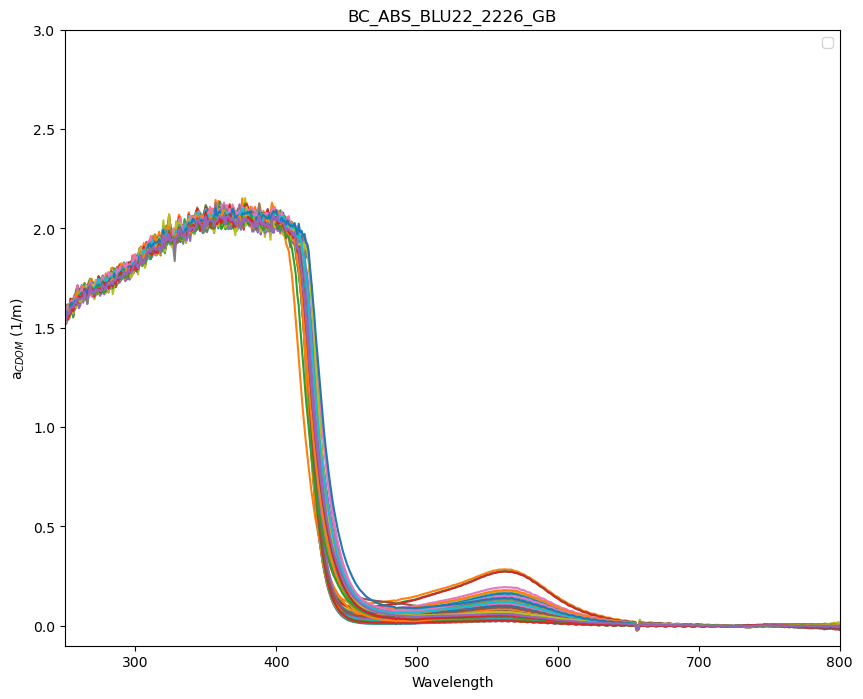

In [6]:
#HERE, WE MAKE A QUICK AND DIRTY GRAPH OF THE DATA TO SAVE AND CHECK WORK 
fig, ax = plt.subplots(figsize=(10,8))
df.plot(label='', ax=ax)
ax.set_ylim(-.1,3)
ax.set_xlim(250,800)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.legend("")
ax.set_title("BC_ABS_BLU22_2226_GB")


Text(0.5, 1.0, 'BC_ABS_BLU22_2226_GB')

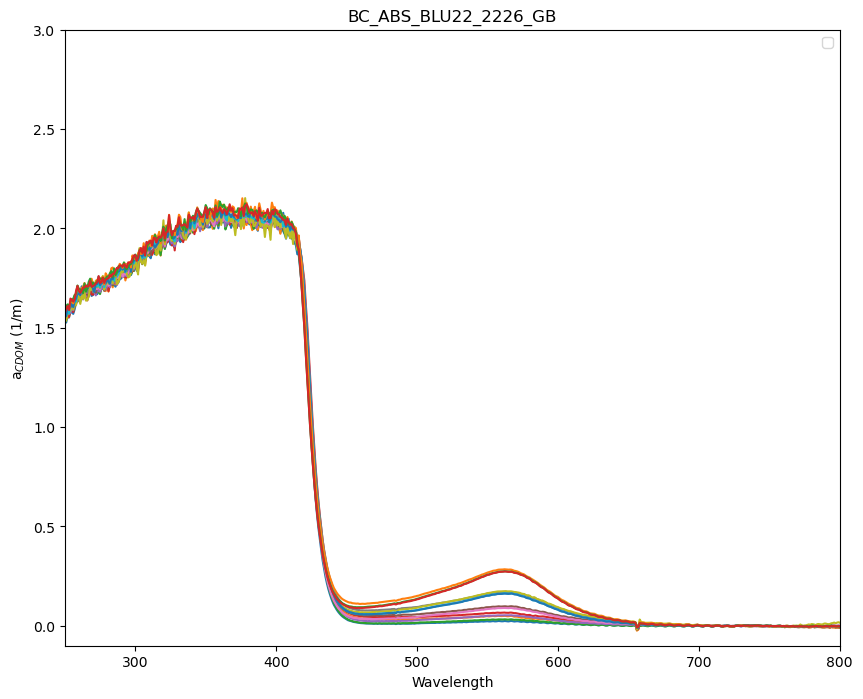

In [7]:
#HERE, WE MAKE A QUICK AND DIRTY GRAPH OF THE DATA TO SAVE AND CHECK WORK 
fig, ax = plt.subplots(figsize=(10,8))
df_nm.plot(label='', ax=ax)
ax.set_ylim(-.1,3)
ax.set_xlim(250,800)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.legend("")
ax.set_title("BC_ABS_BLU22_2226_GB")


PART 1 
THE CURVE

In [8]:
Frames = []
maxfev = 10000000
for (columnName, columnData) in df_nm.items():
    col = columnName
    
    abs_562 = df_nm[(df_nm['wl']==562)][col].mean()
    
    ydata = df_nm[(df_nm['wl']>=450) & (df_nm['wl']<=700)][col]
    xdata = df_nm[(df_nm['wl']>=450) & (df_nm['wl']<=700)]['wl']
    ydata = np.asarray(ydata, dtype=float).ravel()
    xdata = np.asarray(xdata, dtype=float).ravel()
    
    inter = scipy.integrate.simps(ydata, x=xdata, even='avg')
    
    dict = {'sample':[columnName],
        'abs_562':[abs_562], 
        'intagration':[inter],}
    std_outs = pd.DataFrame(dict)
    std_outs = std_outs.set_index('sample', drop=True)
    Frames.append(std_outs)

std_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
std_outs = std_outs.drop('wl')
std_outs['conc'] = std_outs.index.str.rsplit('_', n=7).str[0].astype(int)
std_outs['ID'] = std_outs.index.str.rsplit('Abs', n=7).str[0]

In [9]:
#std_outs = std_outs.drop('010_nm_pre_Absorbance_12-54-26-418.txt', axis = 0)
#std_outs = std_outs.drop('020_nm_pre_Absorbance_12-57-44-229.txt', axis = 0)
#std_outs = std_outs.drop('100_nm_post_Absorbance_16-08-48-309.txt', axis = 0)
std_outs

abs_562  intagration  conc  \
sample                                                                     
000_nm_pre_Absorbance__1__14-59-49-444.txt   0.024293     2.786968     0   
010_nm_post_Absorbance__0__15-55-24-079.txt  0.050199     6.759543    10   
010_nm_pre_Absorbance__0__15-01-21-034.txt   0.032772     3.532236    10   
020_nm_post_Absorbance__0__15-55-59-013.txt  0.066823     9.132033    20   
020_nm_pre_Absorbance__0__15-02-04-016.txt   0.052861     6.349766    20   
050_nm_post_Absorbance__0__15-56-32-244.txt  0.098368    12.343800    50   
050_nm_pre_Absorbance__0__15-02-43-613.txt   0.089909    10.276209    50   
100_nm_post_Absorbance__0__15-57-11-756.txt  0.170988    20.395940   100   
100_nm_pre_Absorbance__0__15-03-22-067.txt   0.174316    20.647905   100   
100_nm_pre_Absorbance__1__15-03-36-772.txt   0.163644    17.990908   100   
100_nm_pre_Absorbance__2__15-03-53-747.txt   0.162421    17.761322   100   
200_nm_post_Absorbance__0__15-57-50-687.txt  0.284759    32.391505   200   
200_nm_pre_Absorbance__0__15-04-34-480.txt   0.275102    30.110975   200   
200_nm_pre_Absorbance__1__15-04-38-442.txt   0.273724    29.733120   200   

                                                       ID  
sample                                                     
000_nm_pre_Absorbance__1__14-59-49-444.txt    000_nm_pre_  
010_nm_post_Absorbance__0__15-55-24-079.txt  010_nm_post_  
010_nm_pre_Absorbance__0__15-01-21-034.txt    010_nm_pre_  
020_nm_post_Absorbance__0__15-55-59-013.txt  020_nm_post_  
020_nm_pre_Absorbance__0__15-02-04-016.txt    020_nm_pre_  
050_nm_post_Absorbance__0__15-56-32-244.txt  050_nm_post_  
050_nm_pre_Absorbance__0__15-02-43-613.txt    050_nm_pre_  
100_nm_post_Absorbance__0__15-57-11-756.txt  100_nm_post_  
100_nm_pre_Absorbance__0__15-03-22-067.txt    100_nm_pre_  
100_nm_pre_Absorbance__1__15-03-36-772.txt    100_nm_pre_  
100_nm_pre_Absorbance__2__15-03-53-747.txt    100_nm_pre_  
200_nm_post_Absorbance__0__15-57-50-687.txt  200_nm_post_  
200_nm_pre_Absorbance__0__15-04-34-480.txt    200_nm_pre_  
200_nm_pre_Absorbance__1__15-04-38-442.txt    200_nm_pre_

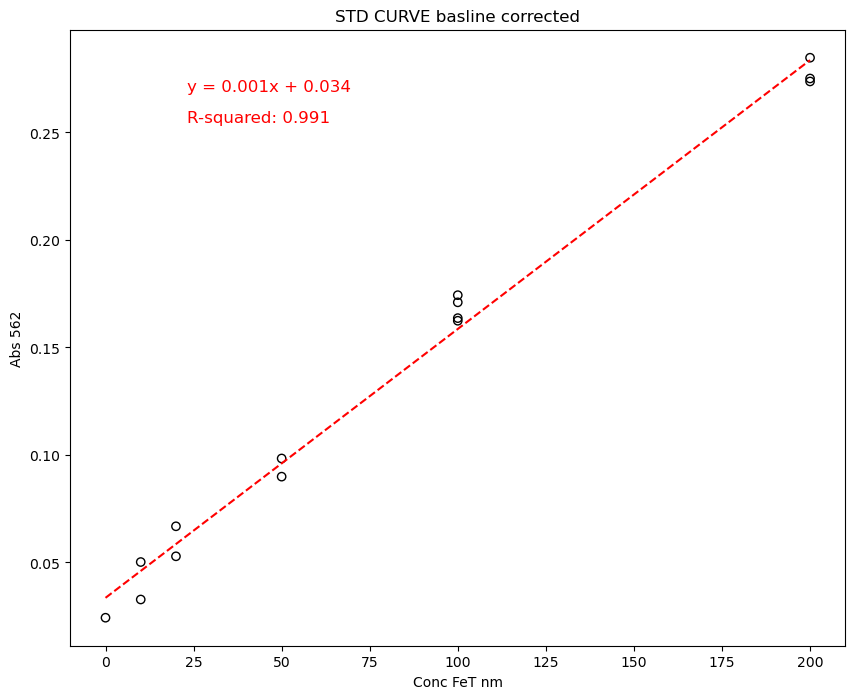

In [10]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(std_outs['conc'], std_outs['abs_562'], facecolor='none', edgecolor='black')

# add linear regression line
x = std_outs['conc']
y = std_outs['abs_562']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared_og1 = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_xlabel('Conc FeT nm')
ax.set_ylabel('Abs 562')
ax.set_title('STD CURVE basline corrected')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared_og1:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')

# show plot
plt.show()


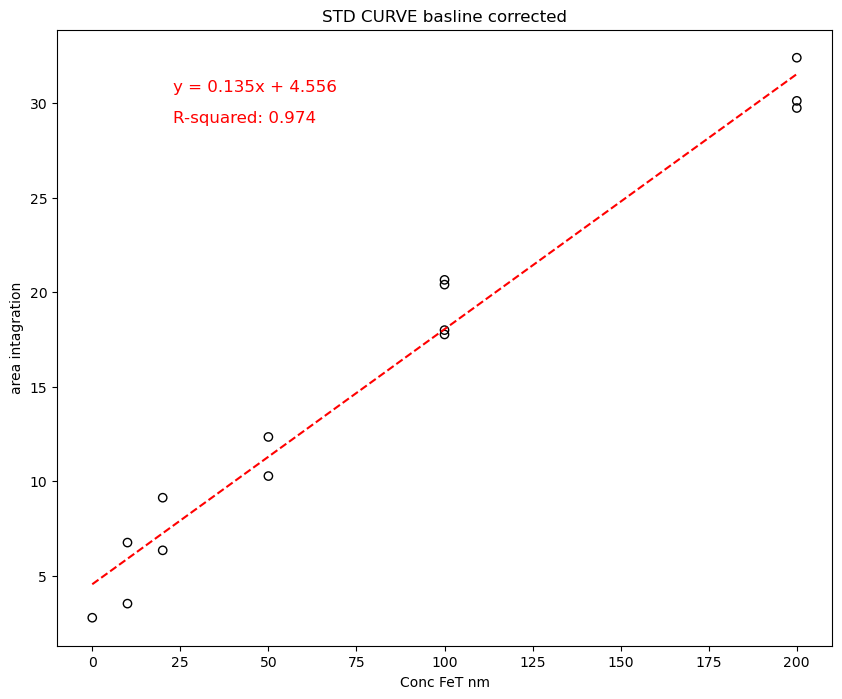

In [11]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(std_outs['conc'], std_outs['intagration'], facecolor='none', edgecolor='black')

# add linear regression line
x = std_outs['conc']
y = std_outs['intagration']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared_og2 = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_xlabel('Conc FeT nm')
ax.set_ylabel('area intagration')
ax.set_title('STD CURVE basline corrected')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared_og2:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')

# show plot
plt.show()

In [12]:
# Group by the new column 'group_name', and calculate the mean and std for each group
grouped = std_outs.groupby('ID')['abs_562'].agg(['mean', 'std'])

# Join the original dataframe with the grouped one
std_outs = std_outs.join(grouped, on='ID')
std_outs["z_score"] = np.abs(std_outs['abs_562'] - std_outs['mean']) / std_outs['std']


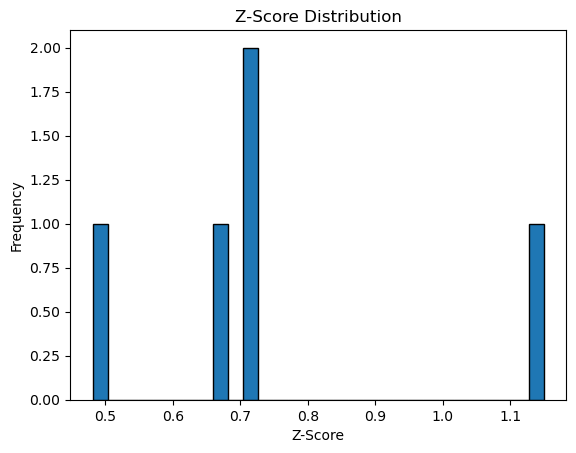

                                             abs_562  intagration  conc  \
sample                                                                    
100_nm_pre_Absorbance__0__15-03-22-067.txt  0.174316    20.647905   100   

                                                     ID      mean       std  \
sample                                                                        
100_nm_pre_Absorbance__0__15-03-22-067.txt  100_nm_pre_  0.166794  0.006543   

                                             z_score  
sample                                                
100_nm_pre_Absorbance__0__15-03-22-067.txt  1.149651  


In [13]:
# Create a mask for rows that are 2 standard deviations away from the mean
mean_z = std_outs['z_score'].mean()
mask = np.abs(std_outs['z_score']) >  mean_z

plt.hist(std_outs['z_score'], bins=30, edgecolor='k')
plt.title('Z-Score Distribution')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.show()

# Print the rows that meet the condition
print(std_outs[mask])

In [14]:
# Group by some column, calculate mean and filter groups where max z_score > mean_z
grouped = std_outs.groupby('ID').filter(lambda x: x['z_score'].max() > mean_z)

# For each group, find the row with the maximum z_score
max_z_scores = grouped.loc[grouped.groupby('ID')['z_score'].idxmax()]

# Print the rows with the highest z_score, the z_score, and other z_scores in the group
for group, data in max_z_scores.groupby('ID'):
    print(f"Group: {group}")
    print(f"Row with highest z_score: \n{data}\n")

# Remove those rows from sub_outs
std_outs = std_outs.drop(max_z_scores.index)

Group: 100_nm_pre_
Row with highest z_score: 
                                             abs_562  intagration  conc  \
sample                                                                    
100_nm_pre_Absorbance__0__15-03-22-067.txt  0.174316    20.647905   100   

                                                     ID      mean       std  \
sample                                                                        
100_nm_pre_Absorbance__0__15-03-22-067.txt  100_nm_pre_  0.166794  0.006543   

                                             z_score  
sample                                                
100_nm_pre_Absorbance__0__15-03-22-067.txt  1.149651  



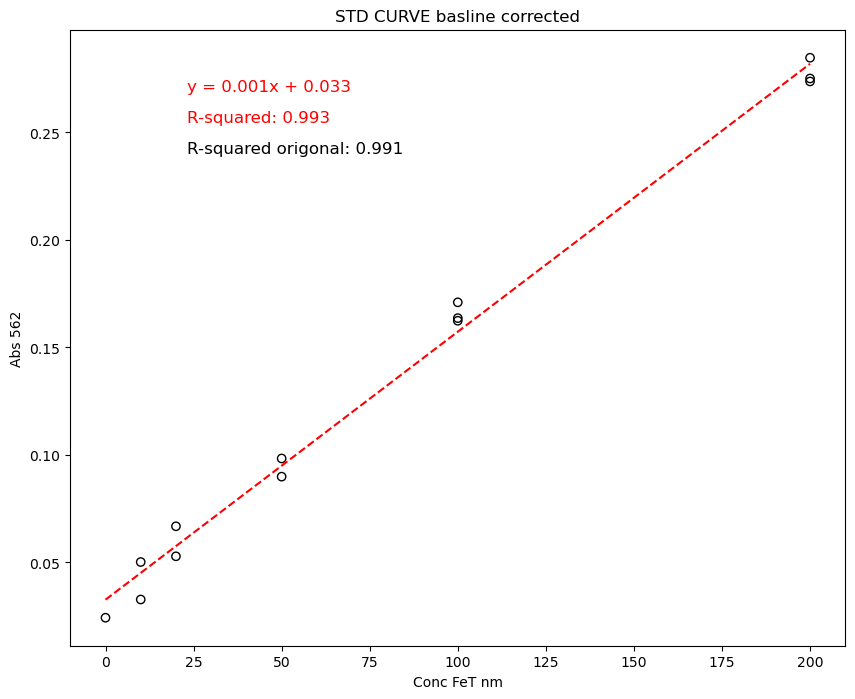

In [15]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(std_outs['conc'], std_outs['abs_562'], facecolor='none', edgecolor='black')

# add linear regression line
x = std_outs['conc']
y = std_outs['abs_562']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared_1 = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_xlabel('Conc FeT nm')
ax.set_ylabel('Abs 562')
ax.set_title('STD CURVE basline corrected')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared_1:.3f}"
r2_text2 = f"R-squared origonal: {r_squared_og1:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.80, r2_text2, transform=ax.transAxes, fontsize=12, color='black')


# show plot
plt.show()


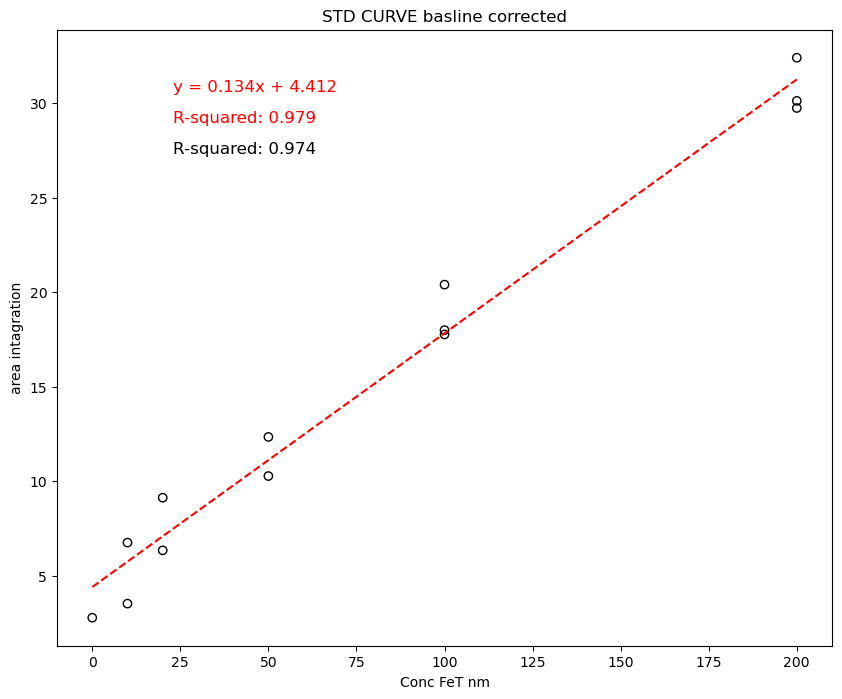

In [16]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(std_outs['conc'], std_outs['intagration'], facecolor='none', edgecolor='black')

# add linear regression line
x = std_outs['conc']
y = std_outs['intagration']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared_2 = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_xlabel('Conc FeT nm')
ax.set_ylabel('area intagration')
ax.set_title('STD CURVE basline corrected')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared_2:.3f}"
r2_text2 = f"R-squared: {r_squared_og2:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.80, r2_text2, transform=ax.transAxes, fontsize=12, color='black')


# show plot
plt.show()

In [17]:
# Set 'conc' as the index of the DataFrame
std_outs.set_index('conc', inplace=True)

# Group by index, calculate the mean of all the columns for each group and convert it to a new DataFrame
std_outs_mean = std_outs #.groupby(std_outs['ID']).mean()

# Now, mean_df is a new DataFrame with the mean of all the columns for each group
std_outs_mean.to_csv(path_save_1)
std_outs_mean

abs_562  intagration            ID      mean       std   z_score
conc                                                                   
0     0.024293     2.786968   000_nm_pre_  0.024293       NaN       NaN
10    0.050199     6.759543  010_nm_post_  0.050199       NaN       NaN
10    0.032772     3.532236   010_nm_pre_  0.032772       NaN       NaN
20    0.066823     9.132033  020_nm_post_  0.066823       NaN       NaN
20    0.052861     6.349766   020_nm_pre_  0.052861       NaN       NaN
50    0.098368    12.343800  050_nm_post_  0.098368       NaN       NaN
50    0.089909    10.276209   050_nm_pre_  0.089909       NaN       NaN
100   0.170988    20.395940  100_nm_post_  0.170988       NaN       NaN
100   0.163644    17.990908   100_nm_pre_  0.166794  0.006543  0.481404
100   0.162421    17.761322   100_nm_pre_  0.166794  0.006543  0.668247
200   0.284759    32.391505  200_nm_post_  0.284759       NaN       NaN
200   0.275102    30.110975   200_nm_pre_  0.274413  0.000975  0.707107
200   0.273724    29.733120   200_nm_pre_  0.274413  0.000975  0.707107

PART 2
THE DATA

In [18]:
Frames = []
maxfev = 10000000
for (columnName, columnData) in df.items():
    col = columnName
    
    abs_562 = df[(df['wl']==562)][col].mean()
    
    ydata = df[(df['wl']>=450) & (df['wl']<=700)][col]
    xdata = df[(df['wl']>=450) & (df['wl']<=700)]['wl']
    ydata = np.asarray(ydata, dtype=float).ravel()
    xdata = np.asarray(xdata, dtype=float).ravel()
    
    inter = scipy.integrate.simps(ydata, x=xdata, even='avg')
    
    dict = {'sample':[columnName],
        'abs_562':[abs_562], 
        'intagration':[inter],}
    sub_outs = pd.DataFrame(dict)
    sub_outs = sub_outs.set_index('sample', drop=True)
    Frames.append(sub_outs)

sub_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
mask = sub_outs.index.str.contains('nm')
sub_outs = sub_outs[~mask]
sub_outs = sub_outs.drop('wl')
sub_outs

abs_562  intagration
sample                                                         
212431_Absorbance__0__15-08-15-564.txt    0.037172     5.562064
212432_Absorbance__0__15-09-34-011.txt    0.046139     7.931176
212432_Absorbance__1__15-10-04-718.txt    0.053910     7.885579
212434_Absorbance__0__15-10-47-430.txt    0.028921     5.453076
212435_Absorbance__0__15-11-18-270.txt    0.025196     4.917924
...                                            ...          ...
LD212740_Absorbance__0__15-49-46-177.txt  0.140645    19.973257
MS212439_Absorbance__0__15-16-56-120.txt  0.050688     7.189096
MS212539_Absorbance__0__15-27-50-698.txt  0.045076     7.491892
MS212639_Absorbance__0__15-39-51-281.txt  0.052100     7.936861
MS212739_Absorbance__0__15-50-25-703.txt  0.057326    10.076310

[61 rows x 2 columns]

In [19]:
# Create a new column 'group_name' that contains the name you're grouping by
sub_outs['group_name'] = sub_outs.index.str.rsplit('_', n=7).str[0]

# Group by the new column 'group_name', and calculate the mean and std for each group
grouped = sub_outs.groupby('group_name')['abs_562'].agg(['mean', 'std'])

# Join the original dataframe with the grouped one
sub_outs = sub_outs.join(grouped, on='group_name')
sub_outs["z_score"] = np.abs(sub_outs['abs_562'] - sub_outs['mean']) / sub_outs['std']

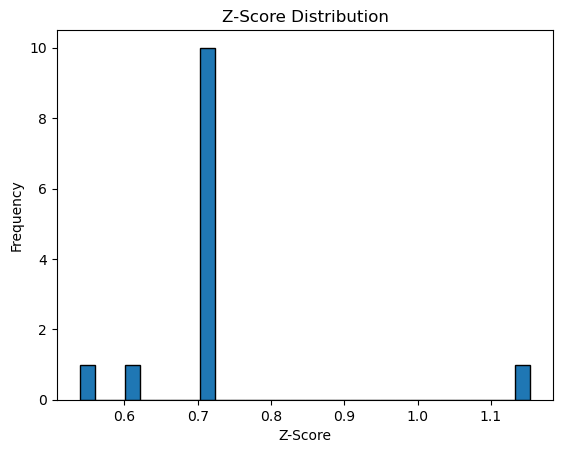

                                      abs_562  intagration group_name  \
sample                                                                  
CS2_Absorbance__0__15-28-38-809.txt  0.123213    13.990989        CS2   

                                         mean      std   z_score  
sample                                                            
CS2_Absorbance__0__15-28-38-809.txt  0.060004  0.05478  1.153861  


In [20]:
# Create a mask for rows that are 2 standard deviations away from the mean
mean_z = sub_outs['z_score'].mean()
mask = np.abs(sub_outs['z_score']) >  mean_z

plt.hist(sub_outs['z_score'], bins=30, edgecolor='k')
plt.title('Z-Score Distribution')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.show()

# Print the rows that meet the condition
sub_outs[mask]
print(sub_outs[mask])

In [21]:
# Group by some column, calculate mean and filter groups where max z_score > mean_z
grouped = sub_outs.groupby('group_name').filter(lambda x: x['z_score'].max() > mean_z)

# For each group, find the row with the maximum z_score
max_z_scores = grouped.loc[grouped.groupby('group_name')['z_score'].idxmax()]

# Print the rows with the highest z_score, the z_score, and other z_scores in the group
for group, data in max_z_scores.groupby('group_name'):
    print(f"Group: {group}")
    print(f"Index of row with highest z_score: \n{data.index}\n")
    print(f"Other z_scores in group: \n{grouped.loc[grouped['group_name'] == group, 'z_score']}\n")

# Remove those rows from sub_outs
sub_outs = sub_outs.drop(max_z_scores.index)

Group: CS2
Index of row with highest z_score: 
Index(['CS2_Absorbance__0__15-28-38-809.txt'], dtype='object', name='sample')

Other z_scores in group: 
sample
CS2_Absorbance__0__15-28-38-809.txt    1.153861
CS2_Absorbance__1__15-29-10-906.txt    0.538807
CS2_Absorbance__2__15-29-34-396.txt    0.615054
Name: z_score, dtype: float64



In [22]:
# Set 'conc' as the index of the DataFrame
sub_outs.set_index('group_name', inplace=True)

# Group by index, calculate the mean of all the columns for each group and convert it to a new DataFrame
sub_outs_mean = sub_outs.groupby(sub_outs.index).mean()

# Now, mean_df is a new DataFrame with the mean of all the columns for each group
sub_outs_mean.to_csv(path_save_2)
sub_outs_mean

abs_562  intagration      mean       std   z_score
group_name                                                     
212431      0.037172     5.562064  0.037172       NaN       NaN
212432      0.050024     7.908378  0.050024  0.005495  0.707107
212434      0.028921     5.453076  0.028921       NaN       NaN
212435      0.025196     4.917924  0.025196       NaN       NaN
212436      0.036491     6.352302  0.036491       NaN       NaN
212437      0.094782    12.793994  0.094782       NaN       NaN
212438      0.048899     7.523300  0.048899       NaN       NaN
212439      0.037931     6.122521  0.037931  0.000600  0.707107
212440      0.085299    11.034479  0.085299       NaN       NaN
212531      0.030442     5.055184  0.030442       NaN       NaN
212532      0.031248     5.950526  0.031248       NaN       NaN
212533      0.035826     6.518310  0.035826       NaN       NaN
212534      0.044244     7.414756  0.044244       NaN       NaN
212535      0.087709    12.006141  0.087709       NaN       NaN
212536      0.044103     6.717429  0.044103       NaN       NaN
212537      0.025125     5.015549  0.025125       NaN       NaN
212538      0.062117     9.108997  0.062117       NaN       NaN
212539      0.043174     8.466347  0.043174       NaN       NaN
212540      0.051933     9.535665  0.051933       NaN       NaN
212631      0.076047    16.196927  0.076047       NaN       NaN
212632      0.031869     5.472408  0.031869       NaN       NaN
212633      0.031338     5.600208  0.031338       NaN       NaN
212634      0.038804     6.539444  0.038804       NaN       NaN
212635      0.043669     7.334825  0.043669       NaN       NaN
212636      0.040891     7.314896  0.040891       NaN       NaN
212637      0.084346    11.608925  0.084346       NaN       NaN
212638      0.042480     7.014856  0.042480       NaN       NaN
212639      0.036588     7.116357  0.036588       NaN       NaN
212640      0.108697    14.455088  0.108697  0.001383  0.707107
212731      0.194569    23.555621  0.194569       NaN       NaN
212732      0.134732    17.027952  0.134732       NaN       NaN
212733      0.149777    18.566178  0.149777       NaN       NaN
212734      0.150948    18.804529  0.150948       NaN       NaN
212735      0.104902    13.501050  0.104902       NaN       NaN
212736      0.180011    21.900393  0.180011       NaN       NaN
212737      0.124023    16.021611  0.124023       NaN       NaN
212738      0.037314     6.614565  0.037314       NaN       NaN
212739      0.047886     9.606858  0.047886       NaN       NaN
212740      0.112090    15.895076  0.112090  0.000768  0.707107
B1          0.027185     3.500552  0.027185       NaN       NaN
B3          0.027037     3.709132  0.027037       NaN       NaN
B4          0.034274     4.934343  0.034274       NaN       NaN
CS1         0.122208    13.711435  0.122208       NaN       NaN
CS2         0.028400     3.700661  0.060004  0.054780  0.576931
CS3         0.063996     8.079156  0.063996       NaN       NaN
CS4         0.092906    11.017484  0.092906       NaN       NaN
LD212440    0.149305    18.701410  0.149305       NaN       NaN
LD212540    0.069738    11.310790  0.069738  0.000159  0.707107
LD212640    0.119662    16.064477  0.119662       NaN       NaN
LD212740    0.140645    19.973257  0.140645       NaN       NaN
MS212439    0.050688     7.189096  0.050688       NaN       NaN
MS212539    0.045076     7.491892  0.045076       NaN       NaN
MS212639    0.052100     7.936861  0.052100       NaN       NaN
MS212739    0.057326    10.076310  0.057326       NaN       NaN